In [1]:
from __future__ import print_function, division

import thinkdsp
import thinkplot
import thinkstats2

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

%matplotlib inline

### Exercise 5
The algorithm in this chapter for generating pink noise is
conceptually simple but computationally expensive.  There are
more efficient alternatives, like the Voss-McCartney algorithm.
Research this method, implement it, compute the spectrum of
the result, and confirm that it has the desired relationship
between power and frequency.

本章中用於產生粉紅噪聲的算法在概念上很簡單，但計算量卻很大。 還有更有效的替代方法，例如Voss-McCartney算法。 研究該方法，實施該方法，計算結果的頻譜，並確認它具有所需的功率和頻率關係。

### Solution
The fundamental idea of this algorithm is to add up several sequences of random numbers that get updates at different sampling rates.  The first source should get updated at every time step; the second source every other time step, the third source ever fourth step, and so on.

In the original algorithm, the updates are evenly spaced.  In an alternative proposed at http://www.firstpr.com.au/dsp/pink-noise/, they are randomly spaced.

My implementation starts with an array with one row per timestep and one column for each of the white noise sources.  Initially, the first row and the first column are random and the rest of the array is Nan.

該算法的基本思想是將幾個隨機數序列加起來，以不同的採樣率進行更新。 第一個來源應在每個時間步進行更新； 第二個來源每隔一個時間步，第三個來源第四個步驟，依此類推。

在原始算法中，更新間隔均勻。 在http://www.firstpr.com.au/dsp/pink-noise/上提出的替代方法中，將它們隨機隔開。

我的實現從一個數組開始，每個時間步長一行，每個白噪聲源一行。 最初，第一行和第一列是隨機的，而數組的其餘部分是Nan。

In [29]:
nrows = 100
ncols = 5

array = np.empty((nrows, ncols))
array.fill(np.nan)
array[0, :] = np.random.random(ncols)
array[:, 0] = np.random.random(nrows)
array[0:6]

array([[0.87321882, 0.15176676, 0.74824816, 0.48519283, 0.78149382],
       [0.1826087 ,        nan,        nan,        nan,        nan],
       [0.78358125,        nan,        nan,        nan,        nan],
       [0.50179242,        nan,        nan,        nan,        nan],
       [0.05859796,        nan,        nan,        nan,        nan],
       [0.9953511 ,        nan,        nan,        nan,        nan]])

The next step is to choose the locations where the random sources change.  If the number of rows is $n$, the number of changes in the first column is $n$, the number in the second column is $n/2$ on average, the number in the third column is $n/4$ on average, etc.

So the total number of changes in the matrix is $2n$ on average; since $n$ of those are in the first column, the other $n$ are in the rest of the matrix.

To place the remaining $n$ changes, we generate random columns from a geometric distribution with $p=0.5$.  If we generate a value out of bounds, we set it to 0 (so the first column gets the extras).

下一步是選擇隨機源發生變化的位置。 如果行數是𝑛，則第一列的更改數是𝑛，第二列的平均數是𝑛/ 2，第三列的平均數是𝑛/ 4等。

因此，矩陣中變化的總數平均為2𝑛。 由於其中的are在第一列中，因此其他𝑛在矩陣的其餘部分中。

為了放置剩餘的𝑛變化，我們從distribution = 0.5的幾何分佈生成隨機列。 如果生成的值超出範圍，則將其設置為0（這樣第一列將獲得額外的值）。

In [30]:
p = 0.5
n = nrows
cols = np.random.geometric(p, n)
cols[cols >= ncols] = 0
cols

array([2, 1, 1, 1, 2, 1, 4, 1, 2, 2, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 0, 2,
       3, 1, 3, 1, 4, 1, 4, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       4, 2, 1, 1, 2, 0, 2, 3, 2, 2, 2, 3, 1, 1, 2, 1, 1, 0, 3, 1, 2, 2,
       1, 0, 1, 3, 1, 2, 3, 2, 1, 1, 2, 2, 3, 1, 1, 2, 1, 1, 2, 1, 1, 2,
       2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1])

Within each column, we choose a random row from a uniform distribution.  Ideally we would choose without replacement, but it is faster and easier to choose with replacement, and I doubt it matters.

在每一列中，我們從均勻分佈中選擇一個隨機行。 理想情況下，我們會選擇不進行替換，但選擇替換起來更快，更容易，我懷疑這很重要。

In [31]:
rows = np.random.randint(nrows, size=n)
rows

array([10, 35, 67, 16, 93, 64, 84, 33, 98, 93, 65, 71, 40, 58, 31, 38, 23,
       84, 88, 32, 84, 77, 71, 82, 59,  6, 57, 32, 23, 54, 25, 61, 21, 37,
       72, 87, 56, 71, 73, 90, 45, 98, 60, 60, 53, 96, 38, 79, 49, 38, 17,
       23, 27, 64, 30, 48, 42, 51, 58, 38, 41, 72, 73, 20,  8,  6, 99, 99,
       21, 13, 82,  1,  1, 79, 26, 42, 19, 96, 50, 44, 33,  4,  6, 44, 58,
       89, 86, 94,  1, 90, 87, 99, 30, 91, 43, 54, 89, 11, 15, 73])

Now we can put random values at rach of the change points.

現在我們可以將隨機值放在每個更改點上。

In [32]:
array[rows, cols] = np.random.random(n)
array[0:6]

array([[0.87321882, 0.15176676, 0.74824816, 0.48519283, 0.78149382],
       [0.1826087 ,        nan, 0.87431626, 0.42643847,        nan],
       [0.78358125,        nan,        nan,        nan,        nan],
       [0.50179242,        nan,        nan,        nan,        nan],
       [0.05859796,        nan, 0.45289471,        nan,        nan],
       [0.9953511 ,        nan,        nan,        nan,        nan]])

Next we want to do a zero-order hold to fill in the NaNs.  NumPy doesn't do that, but Pandas does.  So I'll create a DataFrame:

接下來，我們要進行零級保留以填充NaN。 NumPy不會這樣做，但是Pandas會這樣做。 因此，我將創建一個DataFrame：

In [33]:
df = pd.DataFrame(array)
df.head()

,0,1,2,3,4
0,0.873219,0.151767,0.748248,0.485193,0.781494
1,0.182609,NaN,0.874316,0.426438,NaN
2,0.783581,NaN,NaN,NaN,NaN
3,0.501792,NaN,NaN,NaN,NaN
4,0.058598,NaN,0.452895,NaN,NaN


And then use `fillna` along the columns.

然後沿著列使用`fillna`。

In [34]:
filled = df.fillna(method='ffill', axis=0)
filled.head()

,0,1,2,3,4
0,0.873219,0.151767,0.748248,0.485193,0.781494
1,0.182609,0.151767,0.874316,0.426438,0.781494
2,0.783581,0.151767,0.874316,0.426438,0.781494
3,0.501792,0.151767,0.874316,0.426438,0.781494
4,0.058598,0.151767,0.452895,0.426438,0.781494


Finally we add up the rows.

最後，我們將行加起來。

In [35]:
total = filled.sum(axis=1)
total.head()

0    3.039920
1    2.416624
2    3.017597
3    2.735808
4    1.871192
dtype: float64

If we put the results into a Wave, here's what it looks like:

如果將結果放入Wave中，則結果如下所示：

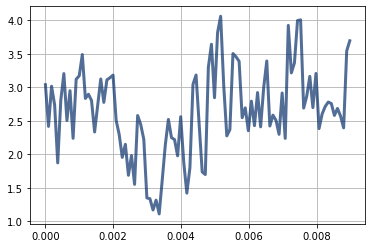

In [36]:
wave = thinkdsp.Wave(total.values)
wave.plot()

Here's the whole process in a function:

這是一個函數的整個過程：

In [37]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

To test it I'll generate 11025 values:

要測試它，我將生成11025個值：

In [38]:
ys = voss(11025)
ys

array([9.37964889, 9.35511304, 8.40084628, ..., 5.60691039, 6.23330807,
       6.29999339])

And make them into a Wave:

並使它們成為Wave：

In [39]:
wave = thinkdsp.Wave(ys)
wave.unbias()
wave.normalize()

Here's what it looks like:

看起來是這樣的：

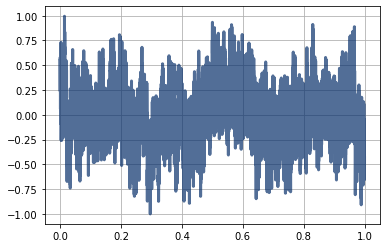

In [40]:
wave.plot()

As expected, it is more random-walk-like than white noise, but more random looking than red noise.

Here's what it sounds like:

不出所料，它比白噪聲更像隨機行走，但比紅噪聲更像隨機行走。

聽起來是這樣的：

In [41]:
wave.make_audio()

And here's the power spectrum:

這是功率譜：

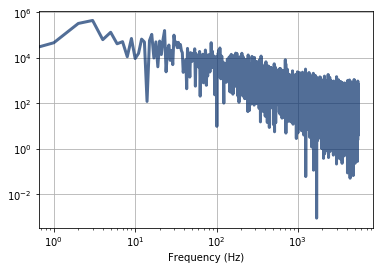

In [42]:
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)',
                 xscale='log', 
                 yscale='log')

The estimated slope is close to -1.

估計的斜率接近-1。

In [43]:
spectrum.estimate_slope().slope

-0.9825800107209125

We can get a better sense of the average power spectrum by generating a longer sample:

通過生成更長的樣本，我們可以更好地了解平均功率譜：

In [44]:
seg_length = 64 * 1024
iters = 100
wave = thinkdsp.Wave(voss(seg_length * iters))
len(wave)

6553600

And using Barlett's method to compute the average.

並使用巴列特的方法來計算平均值。

In [45]:
spectrum = bartlett_method(wave, seg_length=seg_length, win_flag=False)
spectrum.hs[0] = 0
len(spectrum)

32769

It's pretty close to a straight line, with some curvature at the highest frequencies.

它非常接近一條直線，在最高頻率下有些曲率。

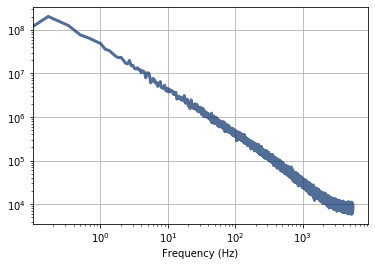

In [46]:
spectrum.plot_power()
thinkplot.config(xlabel='Frequency (Hz)',
                 xscale='log', 
                 yscale='log')

And the slope is close to -1.

斜率接近-1。

In [47]:
spectrum.estimate_slope().slope

-1.001984134321065